In [1]:
import sys

In [2]:
!{sys.executable} -m pip install statsmodels

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ranksums, norm, ttest_ind, levene
import statsmodels.stats.multitest as smt
from matplotlib.patches import Patch
from IPython.display import Image
import re

### Understanding InStrain Output

Looking at profile for sample SRR9113707. 

In [3]:
SRR9113707genome_info = pd.read_csv('data56_related_files/inStrain_output/SRR9113707.IS_genome_info.tsv', sep = '\t')

In [4]:
SRR9113707genome_info

,genome,coverage,breadth,nucl_diversity,length,true_scaffolds,detected_scaffolds,coverage_median,coverage_std,coverage_SEM,...,d_prime_mean,consensus_divergent_sites,population_divergent_sites,SNS_count,SNV_count,filtered_read_pair_count,reads_unfiltered_pairs,reads_mean_PID,divergent_site_count,reads_unfiltered_reads
0,GCA_000615245.1_ASM61524v1_genomic.fna,0.000360,0.000178,NaN,2934843.0,63.0,2.0,0,0.029992,0.000018,...,NaN,0.0,0.0,0.0,0.0,4,14,0.942499,0.0,83
1,GCA_001311745.1_ASM131174v1_genomic.fna,0.000714,0.000368,NaN,2501983.0,141.0,3.0,0,0.042393,0.000027,...,NaN,0.0,0.0,0.0,0.0,7,14,0.962989,0.0,106
2,GCA_001311765.1_ASM131176v1_genomic.fna,0.366775,0.023755,0.007367,2025929.0,114.0,35.0,0,4.153274,0.002935,...,0.990080,647.0,499.0,489.0,509.0,2727,4335,0.961450,998.0,10013
3,GCA_001435375.1_ASM143537v1_genomic.fna,0.791158,0.043833,0.003617,1475258.0,31.0,20.0,0,10.531403,0.008689,...,0.984408,695.0,635.0,633.0,182.0,4295,6389,0.952628,815.0,14600
4,GCA_002299975.1_ASM229997v1_genomic.fna,1.187498,0.120732,0.004095,1190495.0,150.0,95.0,0,5.376973,0.004991,...,0.992153,2232.0,2039.0,2033.0,659.0,5178,17858,0.926796,2692.0,45649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,S49C1120.fna,0.000464,0.000351,NaN,2150582.0,94.0,3.0,0,0.026398,0.000018,...,NaN,0.0,0.0,0.0,0.0,4,4,0.993103,0.0,8
268,S4C569.fna,1.555257,0.508944,0.002743,1644194.0,55.0,51.0,1,2.355166,0.001843,...,1.000000,781.0,605.0,603.0,596.0,9658,9849,0.992523,1199.0,20022
269,S52C595.fna,30.248692,0.997378,0.005779,1721006.0,108.0,108.0,29,13.540489,0.010387,...,0.993587,1632.0,168.0,162.0,26202.0,190823,193814,0.993902,26364.0,392831
270,S5C1113.fna,0.517226,0.175077,0.003021,1744226.0,66.0,60.0,0,1.812200,0.001377,...,1.000000,470.0,388.0,385.0,238.0,3306,3509,0.986430,623.0,7585


### Creating a dictionary with all genome Info dataframes as values to their sampleNames as keys

In [5]:
path = 'data56_related_files/inStrain_output/genome_info/'

In [6]:
sample_df_dict = {}
for filename in os.listdir(path):
    if filename.endswith(".tsv"): 
        file = (os.path.join(path, filename))
        sampleName = (filename[:10])
        df = pd.read_csv(file, sep = '\t')
        sample_df_dict[sampleName] = df    
        continue
    else:
        continue

In [7]:
sample_df_dict.keys()

dict_keys(['SRR6323514', 'SRR6323338', 'SRR9113725', 'SRR6323200', 'SRR6323295', 'SRR6323172', 'SRR6323243', 'ERR2241891', 'SRR9113706', 'ERR2241651', 'SRR6323250', 'SRR6323296', 'ERR2241849', 'SRR6323197', 'SRR6323205', 'SRR6323134', 'SRR6323343', 'SRR6323414', 'SRR6323167', 'ERR2241899', 'ERR2241647', 'ERR2241919', 'ERR2241649', 'ERR2241887', 'SRR6323449', 'SRR6323340', 'SRR6323502', 'SRR6323350', 'ERR2241927', 'ERR2241655', 'SRR6323244', 'SRR6323249', 'SRR6323550', 'SRR6323503', 'ERR2241945', 'SRR6323493', 'ERR2241860', 'SRR6323384', 'ERR2241925', 'SRR6323088', 'SRR6323530', 'SRR9113691', 'SRR6323247', 'ERR2241848', 'ERR2241893', 'ERR2241855', 'SRR9113707', 'SRR6323516', 'SRR9113737', 'ERR2241923', 'ERR2241856', 'ERR2241890', 'ERR2241653', 'SRR6323556', 'SRR6323252', 'SRR6323367'])

In [8]:
sample_df_dict['SRR9113737']

,genome,coverage,breadth,nucl_diversity,length,true_scaffolds,detected_scaffolds,coverage_median,coverage_std,coverage_SEM,...,d_prime_mean,consensus_divergent_sites,population_divergent_sites,SNS_count,SNV_count,filtered_read_pair_count,reads_unfiltered_pairs,reads_mean_PID,reads_unfiltered_reads,divergent_site_count
0,GCA_001311425.1_ASM131142v1_genomic.fna,0.000376,0.000111,NaN,3009421.0,108.0,1.0,0,0.037469,0.000022,...,NaN,0.0,0.0,0.0,0.0,4,6,0.946118,21,0.0
1,GCA_001311745.1_ASM131174v1_genomic.fna,0.002189,0.000404,0.004121,2501983.0,141.0,3.0,0,0.155992,0.000099,...,NaN,0.0,0.0,0.0,1.0,20,24,0.955050,70,1.0
2,GCA_001311765.1_ASM131176v1_genomic.fna,0.864116,0.016931,0.005568,2025929.0,114.0,27.0,0,12.025872,0.008497,...,0.988013,576.0,490.0,477.0,373.0,6406,10694,0.959319,24582,850.0
3,GCA_001435375.1_ASM143537v1_genomic.fna,0.104168,0.015359,0.004900,1475258.0,31.0,19.0,0,1.580280,0.001304,...,1.000000,157.0,137.0,136.0,74.0,561,911,0.947433,2074,210.0
4,GCA_002299975.1_ASM229997v1_genomic.fna,0.850298,0.099734,0.003239,1190495.0,150.0,90.0,0,3.870157,0.003593,...,0.995983,1660.0,1565.0,1575.0,397.0,3698,13709,0.926474,35786,1972.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,S4C569.fna,24.208024,0.888124,0.003109,1644194.0,55.0,51.0,22,18.883308,0.014776,...,0.992539,7761.0,5519.0,5500.0,9306.0,146726,148858,0.992046,300660,14806.0
290,S52C595.fna,82.446466,0.998666,0.002305,1721006.0,108.0,108.0,77,37.759484,0.028965,...,0.994257,427.0,276.0,260.0,5788.0,517912,519995,0.997472,1051661,6048.0
291,S5C1113.fna,0.218414,0.054133,0.003050,1744226.0,66.0,52.0,0,2.112289,0.001605,...,1.000000,281.0,240.0,236.0,111.0,1393,1576,0.982827,3575,347.0
292,S8C2455.fna,0.000336,0.000118,NaN,2459319.0,16.0,1.0,0,0.031264,0.000020,...,NaN,0.0,0.0,0.0,0.0,3,3,0.998851,8,0.0


### Keeping rows in df that have breadth ≥ 0.5 (Aka present genomes) 

In [9]:
for key in sample_df_dict:
    sample_df_dict[key] = sample_df_dict[key][sample_df_dict[key]['breadth'] >= 0.5]

In [10]:
sample_df_dict['SRR9113737']

,genome,coverage,breadth,nucl_diversity,length,true_scaffolds,detected_scaffolds,coverage_median,coverage_std,coverage_SEM,...,d_prime_mean,consensus_divergent_sites,population_divergent_sites,SNS_count,SNV_count,filtered_read_pair_count,reads_unfiltered_pairs,reads_mean_PID,reads_unfiltered_reads,divergent_site_count
18,GCF_000159355.1_ASM15935v1_genomic.fna,10.894628,0.638092,0.002780,1780499.0,32.0,9.0,5,16.991962,0.012757,...,0.994923,6779.0,5702.0,5689.0,4672.0,71549,74156,0.973689,150941,10361.0
19,GCF_000159435.1_ASM15943v1_genomic.fna,5.272091,0.685744,0.003147,1877332.0,112.0,41.0,3,6.467687,0.004749,...,0.990399,3078.0,2054.0,2067.0,4200.0,36307,37654,0.970003,78691,6267.0
47,GCF_000614735.1_ASM61473v1_genomic.fna,112.460415,0.943509,0.007117,1918774.0,74.0,69.0,99,98.522592,0.071401,...,0.950691,6651.0,2471.0,2429.0,33151.0,793464,809298,0.987219,1651572,35580.0
48,GCF_000615285.1_ASM61528v1_genomic.fna,34.444695,0.748058,0.007080,1902496.0,35.0,32.0,24,42.902854,0.031162,...,0.979687,19498.0,13725.0,13527.0,24800.0,240561,264813,0.975195,551195,38327.0
151,GCF_002088015.1_ASM208801v1_genomic.fna,8.459936,0.709072,0.004966,2069542.0,129.0,114.0,4,22.359650,0.015641,...,0.940477,4828.0,2583.0,2566.0,9343.0,64613,71059,0.987016,153437,11909.0
271,S13C2782.fna,4.025967,0.650699,0.005639,1353779.0,44.0,44.0,2,5.240396,0.004519,...,0.990770,2934.0,1724.0,1714.0,4445.0,19995,20883,0.987801,42397,6159.0
274,S14C589.fna,15.389621,0.925160,0.002632,1740998.0,132.0,132.0,14,11.285339,0.008619,...,0.996720,4601.0,3094.0,3077.0,7653.0,97695,98563,0.993310,202005,10730.0
276,S16C442.fna,5.884845,0.780152,0.003863,1576810.0,164.0,164.0,4,6.353483,0.005113,...,0.997697,2769.0,1572.0,1563.0,4898.0,34061,34323,0.991875,69426,6461.0
278,S18C2441.fna,6.569209,0.762464,0.004179,1524374.0,45.0,45.0,4,7.625732,0.006195,...,0.993444,4000.0,2456.0,2445.0,5447.0,36949,39445,0.989173,80589,7892.0
279,S20C3157.fna,3.418263,0.584222,0.005596,1503306.0,33.0,33.0,1,4.782514,0.003909,...,0.998055,3022.0,1915.0,1905.0,4055.0,18851,19858,0.986139,40323,5960.0


### Reducing the df to a list of present genomes

In [11]:
for key in sample_df_dict:
    sample_df_dict[key] = sample_df_dict[key]['genome']

In [12]:
sample_df_dict['SRR9113737']

18      GCF_000159355.1_ASM15935v1_genomic.fna
19      GCF_000159435.1_ASM15943v1_genomic.fna
47      GCF_000614735.1_ASM61473v1_genomic.fna
48      GCF_000615285.1_ASM61528v1_genomic.fna
151    GCF_002088015.1_ASM208801v1_genomic.fna
271                               S13C2782.fna
274                                S14C589.fna
276                                S16C442.fna
278                               S18C2441.fna
279                               S20C3157.fna
280                                S24C362.fna
283                                 S2C205.fna
284                                S2C3320.fna
289                                 S4C569.fna
290                                S52C595.fna
Name: genome, dtype: object

In [13]:
len(sample_df_dict.keys())

56

In [14]:
df = pd.concat([
          pd.Series(v, name=k).astype(str) for k, v in sample_df_dict.items()
     ], 
     axis=1)
binary_sample_vs_genomes = pd.get_dummies(df.stack()).sum(level=1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  """


In [15]:
reference_genomes = list(binary_sample_vs_genomes.columns)

In [16]:
pd.DataFrame(reference_genomes)[:-1].to_csv('\data56_related_files\present_ref_genomes.tsv', index =False, header = False)

In [17]:
binary_sample_vs_genomes.columns.str.rsplit('_',2)[0][0]

'GCA_900557215.1'

In [18]:
binary_sample_vs_genomes = binary_sample_vs_genomes.rename(columns = lambda x: re.sub('(?<=.1_).*$', '', x))

In [19]:
binary_sample_vs_genomes['ID'] = binary_sample_vs_genomes.index

In [20]:
binary_sample_vs_genomes

,GCA_900557215.1_,GCF_000016825.1_,GCF_000159355.1_,GCF_000159435.1_,GCF_000160575.1_,GCF_000193635.1_,GCF_000423265.1_,GCF_000614735.1_,GCF_000615285.1_,GCF_001433855.1_,...,S33C4056.fna,S36C1134.fna,S42C891.fna,S49C1120.fna,S4C569.fna,S52C595.fna,S5C1113.fna,S8C2455.fna,S9C3913.fna,ID
SRR9113707,1,0,0,1,0,0,0,1,1,0,...,0,0,0,0,1,1,0,0,0,SRR9113707
ERR2241649,1,1,1,1,0,0,1,1,0,0,...,0,0,0,0,1,0,1,0,0,ERR2241649
ERR2241899,1,0,1,1,0,0,1,1,1,0,...,0,1,0,0,1,0,1,0,0,ERR2241899
ERR2241647,1,1,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,ERR2241647
ERR2241849,1,0,1,1,0,0,0,1,0,0,...,0,1,0,0,1,0,1,0,0,ERR2241849
ERR2241887,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,ERR2241887
ERR2241860,1,0,1,1,0,0,1,1,0,0,...,0,1,0,0,1,0,1,1,1,ERR2241860
ERR2241919,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,ERR2241919
SRR9113691,0,0,1,1,0,0,0,1,1,0,...,0,0,0,0,1,1,0,0,0,SRR9113691
SRR6323338,0,0,1,1,0,0,1,1,0,0,...,1,1,0,0,1,0,1,0,1,SRR6323338


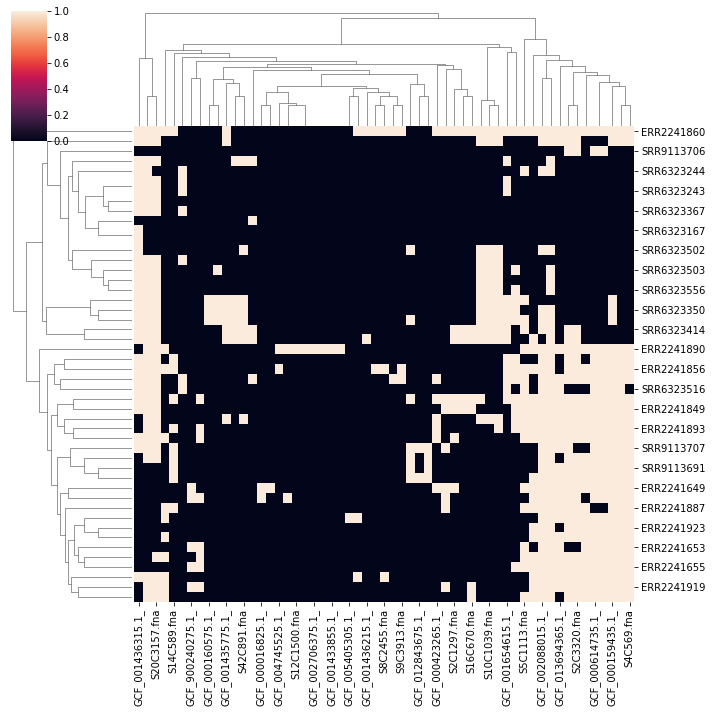

In [21]:
# fig, ax = plt.subplots(figsize=(18, 10) )

sns.clustermap( data = binary_sample_vs_genomes.drop('ID', axis=1))

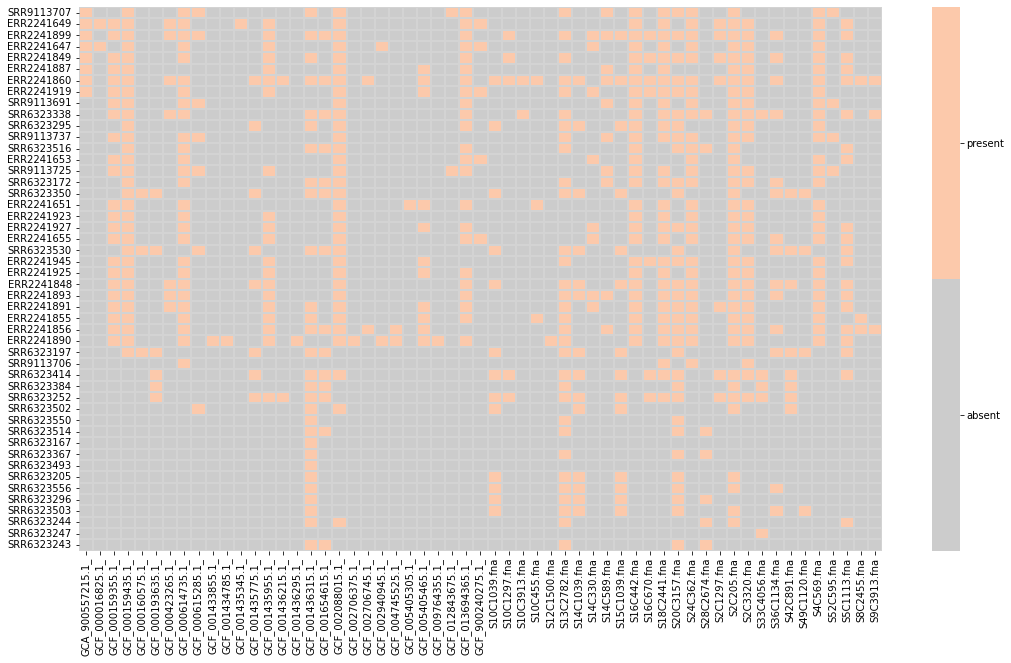

In [22]:
fig, ax = plt.subplots(figsize=(18, 10) )

# sns.heatmap(ax = ax, data = binary_sample_vs_genomes.drop('ID', axis=1))


from matplotlib.colors import LinearSegmentedColormap

# sns.set(font_scale=0.8)

# For only three colors, it's easier to choose them yourself.
# If you still really want to generate a colormap with cubehelix_palette instead,
# add a cbar_kws={"boundaries": linspace(-1, 1, 4)} to the heatmap invocation
# to have it generate a discrete colorbar instead of a continous one.
# myColors = ((0.02, 0.02, 0.05, 1.0),(0.99, 0.79, 0.47, 1.0))
myColors = ((0.8, 0.8, 0.8, 1.0),(0.99, 0.79, 0.67, 1.0))
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

ax = sns.heatmap(data =  binary_sample_vs_genomes.drop('ID', axis=1), cmap=cmap, 
                 linewidths=.1, linecolor='lightgray')

# Manually specify colorbar labelling after it's been generated
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.25, 0.75])
colorbar.set_ticklabels(['absent', 'present'])

In [54]:
sorted(binary_sample_vs_genomes.drop('ID', axis=1).sum())

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 4,
 4,
 5,
 5,
 5,
 6,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 10,
 11,
 13,
 14,
 14,
 14,
 14,
 20,
 20,
 23,
 23,
 27,
 27,
 27,
 28,
 28,
 29,
 29,
 31,
 32,
 32,
 33,
 38]

In [55]:
binary_sample_vs_genomes.drop('ID', axis=1).sum().describe()

count    57.000000
mean     11.701754
std      11.117819
min       1.000000
25%       2.000000
50%       7.000000
75%      20.000000
max      38.000000
dtype: float64

In [56]:
sorted(binary_sample_vs_genomes.sum(axis=1))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


[1,
 1,
 1,
 3,
 4,
 4,
 5,
 5,
 6,
 7,
 7,
 8,
 8,
 8,
 9,
 11,
 12,
 13,
 13,
 14,
 14,
 14,
 15,
 15,
 15,
 15,
 16,
 16,
 16,
 16,
 16,
 16,
 17,
 18,
 18,
 19,
 19,
 19,
 19,
 20,
 20,
 21,
 22,
 22,
 23,
 24,
 27,
 35]

In [57]:
binary_sample_vs_genomes.sum(axis=1).describe()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


count    48.000000
mean     13.895833
std       7.305607
min       1.000000
25%       8.000000
50%      15.000000
75%      19.000000
max      35.000000
dtype: float64

### Checking that all bins are present as reference genome

In [25]:
ref_Names = binary_sample_vs_genomes.columns

count = 0
for name in ref_Names:
    if name.startswith("S"):
#         print(name)
        count += 1
print(count)
# The original number of bins used as a reference was 28 after dRep with all the db ref. genomes. 
# The bins are created from the samples so if they are not present something went wrong.

28


### Which samples do not have any Lactobacillaceae ?

In [26]:
positive_samples = list(binary_sample_vs_genomes['ID'])

all_samples = list(sample_df_dict.keys())

In [27]:
len(positive_samples)

48

In [28]:
len(all_samples)

56

In [29]:
negative_samples = set(positive_samples).symmetric_difference(set(all_samples))

In [30]:
negative_samples

{'SRR6323088',
 'SRR6323134',
 'SRR6323200',
 'SRR6323249',
 'SRR6323250',
 'SRR6323340',
 'SRR6323343',
 'SRR6323449'}

8 samples not containing any Lactobacillaceae reads (with breadth above 50%). All of them are samples from farms in China - see below when combined with metadata

### Including Metadata

In [31]:
metadata = pd.read_csv('data56_related_files/Metadata_56samples.tsv', sep = '\t')

In [32]:
metadata

,Dataset,ID,Country,gender,"age,days,",Breed,"isolation,location",type,Feed,Temperature,...,vaccine,vægt,humidity,"sequencing,method","DNA,extraction","Sample,replicate","location_name,farm,",farm_ID,G bases,avg Mbases
0,Huang,SRR6323134,China,male,42,Arbor Acres broiler,cecum,broiler,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,Combined Newcastle disease virus (NDV) and inf...,NaN,NaN,HiSeq X Ten,NaN,pooled digesta from five chickens,China:Beijing,china1,"2,40",NaN
1,Huang,SRR6323252,China,male,42,Arbor Acres broiler,duodenum,broiler,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,Combined Newcastle disease virus (NDV) and inf...,NaN,NaN,HiSeq X Ten,NaN,pooled digesta from five chickens,China:Beijing,china1,"2,80",NaN
2,Huang,SRR6323384,China,male,42,Arbor Acres broiler,ileum,broiler,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,Combined Newcastle disease virus (NDV) and inf...,NaN,NaN,HiSeq X Ten,NaN,pooled digesta from five chickens,China:Beijing,china1,"2,60",NaN
3,Huang,SRR6323414,China,male,42,Arbor Acres broiler,jejunum,broiler,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,Combined Newcastle disease virus (NDV) and inf...,NaN,NaN,HiSeq X Ten,NaN,pooled digesta from five chickens,China:Beijing,china1,"3,00",NaN
4,Huang,SRR6323550,China,male,42,Arbor Acres broiler,colorectum,broiler,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,Combined Newcastle disease virus (NDV) and inf...,NaN,NaN,HiSeq X Ten,NaN,pooled digesta from five chickens,China:Beijing,china1,"3,00",NaN
5,Huang,SRR6323556,China,female,42,Local yellow-feather chickens,cecum,layer,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,Combined Newcastle disease virus (NDV) and inf...,NaN,NaN,HiSeq X Ten,NaN,pooled digesta from five chickens,China:Hunan,china2,"4,60",NaN
6,Huang,SRR6323530,China,female,42,Local yellow-feather chickens,ileum,layer,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,Combined Newcastle disease virus (NDV) and inf...,NaN,NaN,HiSeq X Ten,NaN,pooled digesta from five chickens,China:Hunan,china2,"2,50",NaN
7,Huang,SRR6323503,China,female,42,Local yellow-feather chickens,colorectum,layer,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,Combined Newcastle disease virus (NDV) and inf...,NaN,NaN,HiSeq X Ten,NaN,pooled digesta from five chickens,China:Hunan,china2,"4,20",NaN
8,Huang,SRR6323350,China,female,42,Local yellow-feather chickens,jejunum,layer,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,Combined Newcastle disease virus (NDV) and inf...,NaN,NaN,HiSeq X Ten,NaN,pooled digesta from five chickens,China:Hunan,china2,"1,70",NaN
9,Huang,SRR6323197,China,female,42,Local yellow-feather chickens,duodenum,layer,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,Combined Newcastle disease virus (NDV) and inf...,NaN,NaN,HiSeq X Ten,NaN,pooled digesta from five chickens,China:Hunan,china2,"3,20",NaN


In [33]:
metadata['location_name,farm,'] = metadata['location_name,farm,'].str.replace('UK:South-east England', 'UK')

In [34]:
metadata.columns

Index(['Dataset', 'ID', 'Country', 'gender', 'age,days,', 'Breed',
       'isolation,location', 'type', 'Feed', 'Temperature', 'Lys', 'Housing',
       'vaccine', 'vægt', 'humidity', 'sequencing,method', 'DNA,extraction',
       'Sample,replicate', 'location_name,farm,', 'farm_ID', 'G bases',
       'avg Mbases'],
      dtype='object')

#### Metadata on the samples with no Lactobacillacea reads

In [35]:
metadata[metadata['ID'].isin(negative_samples)]

,Dataset,ID,Country,gender,"age,days,",Breed,"isolation,location",type,Feed,Temperature,...,vaccine,vægt,humidity,"sequencing,method","DNA,extraction","Sample,replicate","location_name,farm,",farm_ID,G bases,avg Mbases
0,Huang,SRR6323134,China,male,42,Arbor Acres broiler,cecum,broiler,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,Combined Newcastle disease virus (NDV) and inf...,NaN,NaN,HiSeq X Ten,NaN,pooled digesta from five chickens,China:Beijing,china1,"2,40",NaN
10,Huang,SRR6323250,China,male,42,Arbor Acres broiler,cecum,broiler,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,Combined Newcastle disease virus (NDV) and inf...,NaN,NaN,HiSeq X Ten,NaN,digesta from one chicken (biological replicate 2),China:Beijing,china3,"3,50",NaN
11,Huang,SRR6323249,China,male,42,Arbor Acres broiler,cecum,broiler,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,Combined Newcastle disease virus (NDV) and inf...,NaN,NaN,HiSeq X Ten,NaN,digesta from one chicken (biological replicate 1),China:Beijing,china3,"3,10",NaN
13,Huang,SRR6323200,China,female,56,Local yellow-feather chickens,cecum,layer,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,Combined Newcastle disease virus (NDV) and inf...,NaN,NaN,Illumina HiSeq 2500,NaN,digesta from one chicken (biological replicate 3),China:Hunan,china4,"5,00",NaN
17,Huang,SRR6323343,China,female,62,Yellow dwarf chicken,colorectum,broiler,not collected,reduced from 35 °C on day 1 to 24 °C on day 21...,...,Combined Newcastle disease virus (NDV) and inf...,NaN,NaN,HiSeq X Ten,NaN,digesta from one chicken (biological replicate 2),China:Guandong,china5,"5,50",NaN
18,Huang,SRR6323088,China,female,62,Yellow dwarf chicken,cecum,broiler,not collected,reduced from 35 °C on day 1 to 24 °C on day 21...,...,Combined Newcastle disease virus (NDV) and inf...,NaN,NaN,Illumina HiSeq 2500,NaN,digesta from one chicken (biological replicate 1),China:Guandong,china5,"4,60",NaN
20,Huang,SRR6323340,China,male,62,Yellow dwarf chicken,cecum,broiler,not collected,reduced from 35 °C on day 1 to 24 °C on day 21...,...,Combined Newcastle disease virus (NDV) and inf...,NaN,NaN,HiSeq X Ten,NaN,digesta from one chicken (biological replicate 2),China:Guandong,china5,"6,90",NaN
21,Huang,SRR6323449,China,female,78,Guangxi local chicken,cecum,broiler,not collected,reduced from 35 °C on day 1 to 24 °C on day 21...,...,Combined Newcastle disease virus (NDV) and inf...,NaN,NaN,Illumina HiSeq 2500,NaN,digesta from one chicken (biological replicate 3),China:Hunan,china6,"4,10",NaN


#### Combining metadata with binary sample vs genome matrix 

In [36]:
meta_binary_genome_info = pd.merge(metadata, binary_sample_vs_genomes, how="inner", on='ID')

In [37]:
meta_binary_genome_info

,Dataset,ID,Country,gender,"age,days,",Breed,"isolation,location",type,Feed,Temperature,...,S2C3320.fna,S33C4056.fna,S36C1134.fna,S42C891.fna,S49C1120.fna,S4C569.fna,S52C595.fna,S5C1113.fna,S8C2455.fna,S9C3913.fna
0,Huang,SRR6323252,China,male,42,Arbor Acres broiler,duodenum,broiler,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,1,1,0,1,0,0,0,0,0,0
1,Huang,SRR6323384,China,male,42,Arbor Acres broiler,ileum,broiler,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,0,1,0,1,0,0,0,0,0,0
2,Huang,SRR6323414,China,male,42,Arbor Acres broiler,jejunum,broiler,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,1,1,0,1,0,0,0,1,0,0
3,Huang,SRR6323550,China,male,42,Arbor Acres broiler,colorectum,broiler,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,0,0,0,0,0,0,0,0,0,0
4,Huang,SRR6323556,China,female,42,Local yellow-feather chickens,cecum,layer,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,0,0,1,0,0,0,0,0,0,0
5,Huang,SRR6323530,China,female,42,Local yellow-feather chickens,ileum,layer,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,0,0,1,1,1,0,0,1,0,0
6,Huang,SRR6323503,China,female,42,Local yellow-feather chickens,colorectum,layer,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,0,0,1,0,1,0,0,0,0,0
7,Huang,SRR6323350,China,female,42,Local yellow-feather chickens,jejunum,layer,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,0,0,1,1,1,0,0,0,0,0
8,Huang,SRR6323197,China,female,42,Local yellow-feather chickens,duodenum,layer,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,0,0,1,1,1,0,0,1,0,0
9,Huang,SRR6323247,China,male,42,Arbor Acres broiler,cecum,broiler,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,0,1,0,0,0,0,0,0,0,0


<AxesSubplot:xlabel='farm_ID'>

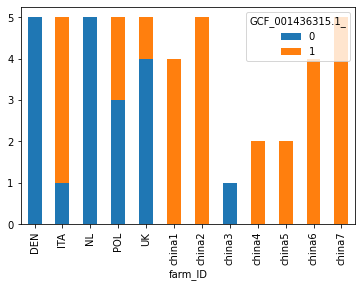

In [38]:
pd.crosstab(meta_binary_genome_info['farm_ID'],meta_binary_genome_info['GCF_001436315.1_']).plot.bar(stacked=True)

# GCF_000159435.1_ASM15943v1_genomic.fna   


In [39]:
meta_binary_genome_info.to_csv('data56_related_files/meta_binary_genome_info_instrain.csv', index = False, header = True)

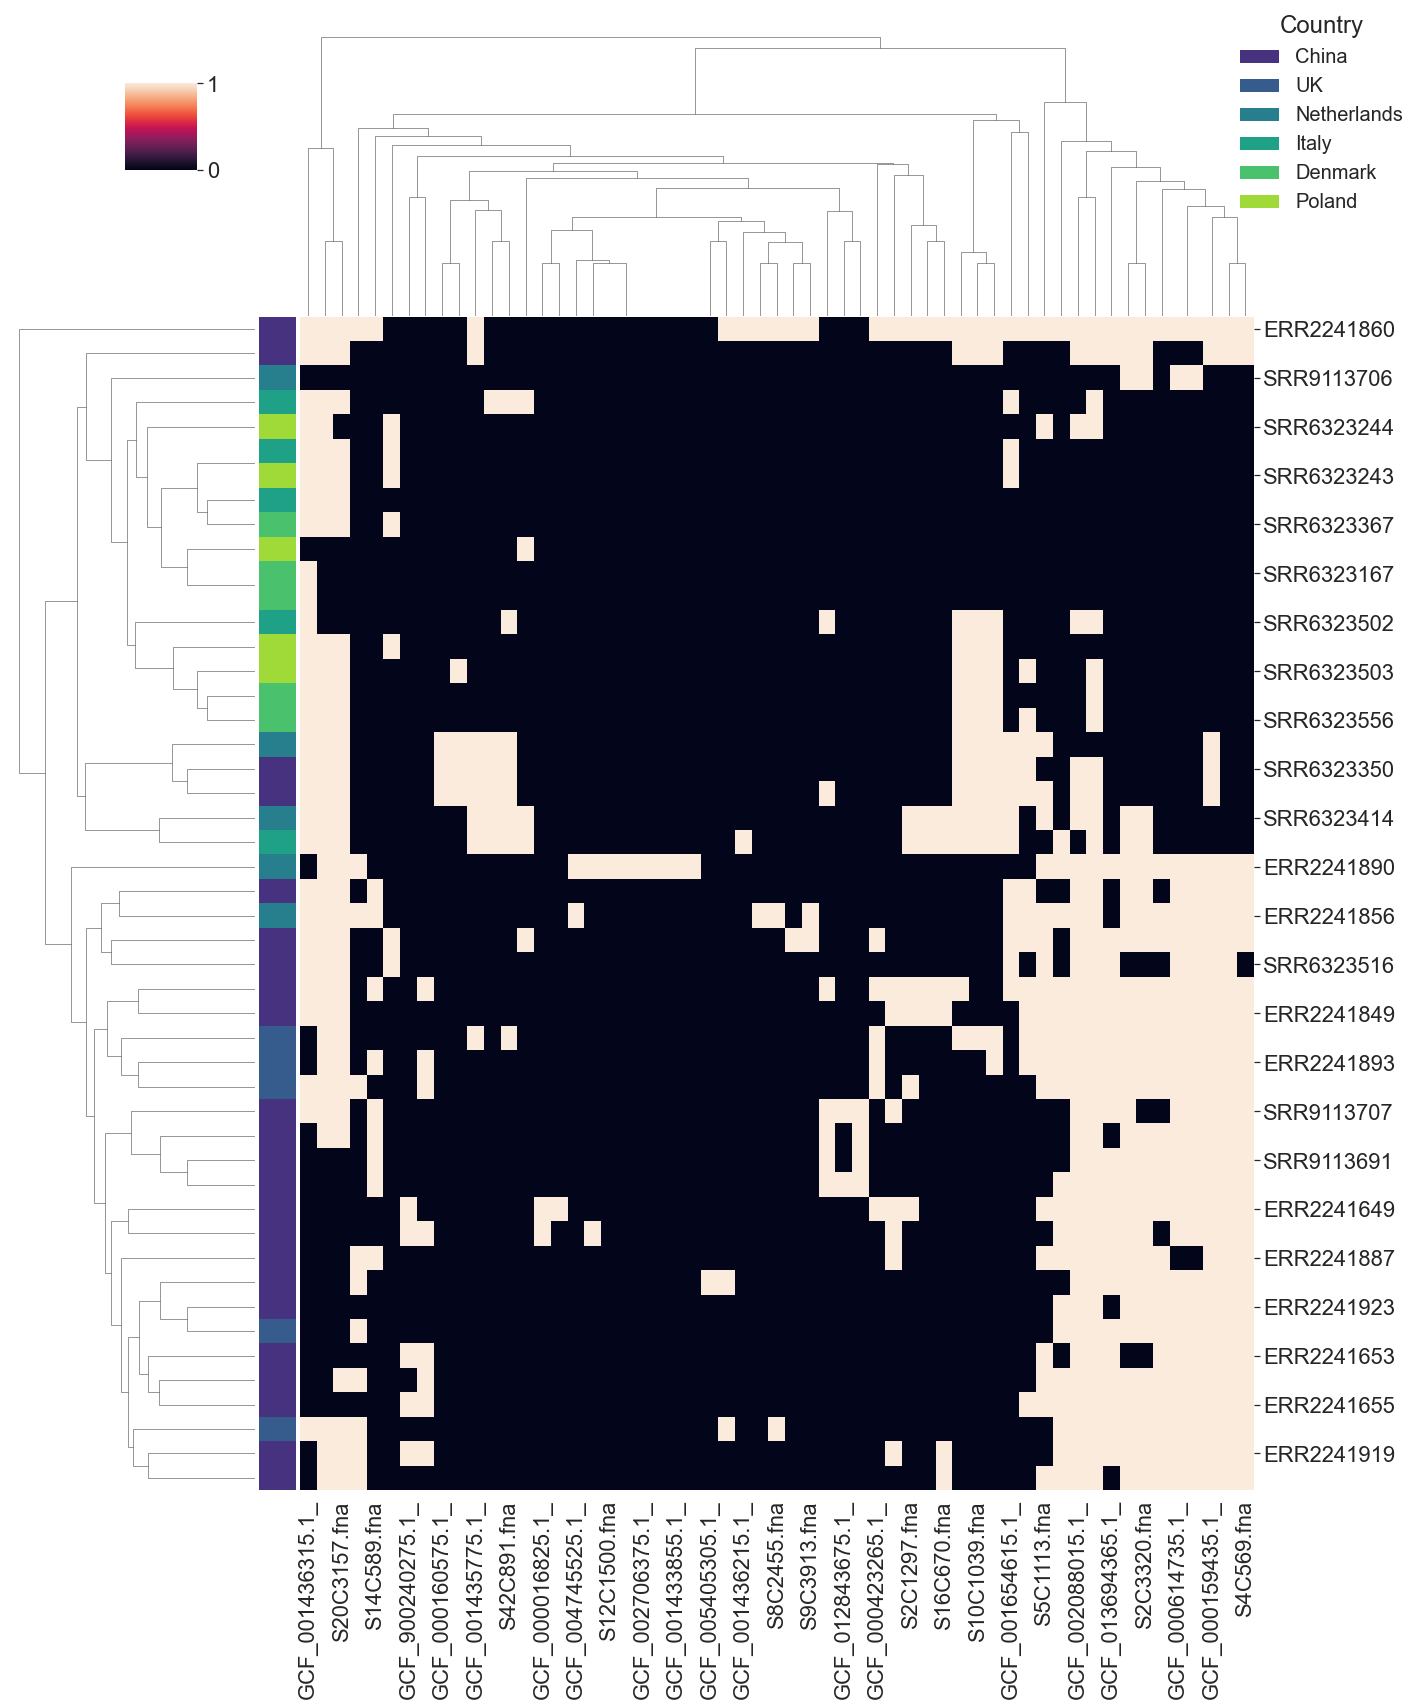

In [40]:
# lut1 = dict(zip(meta_binary_genome_info['Country'].unique(), ['#FFFF99','#330000','#555555','#330066','#CC6600','#009900']))
lut1 = dict(zip(meta_binary_genome_info['Country'].unique(), 
                sns.color_palette("viridis", 6)))

row_colors1 = meta_binary_genome_info['Country'].map(lut1)


sns.set(font_scale = 2)
sns.clustermap( data = binary_sample_vs_genomes.drop('ID', axis=1), 
                    row_colors=[row_colors1], figsize=(20,24),
                    cbar_pos=(0.1, 0.9, 0.05, 0.05) ) 


handles = [Patch(facecolor=lut1[name]) for name in lut1]
plt.legend(handles, lut1, title='Country',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure,
           loc='upper right', fontsize=20, frameon=False )

plt.savefig('resultFigs/presence_apsencePlot.png',  bbox_inches='tight')

# Set the colorbar labels - hjælp johan
# colorbar = ax.collections[0].colorbar
# colorbar.set_ticks([0.25,0.75])
# colorbar.set_ticklabels(['0', '1'])


In [41]:
#sample with the most genomes present 
meta_binary_genome_info[meta_binary_genome_info['ID'] == 'ERR2241860']

,Dataset,ID,Country,gender,"age,days,",Breed,"isolation,location",type,Feed,Temperature,...,S2C3320.fna,S33C4056.fna,S36C1134.fna,S42C891.fna,S49C1120.fna,S4C569.fna,S52C595.fna,S5C1113.fna,S8C2455.fna,S9C3913.fna
37,Patrik Munk,ERR2241860,Italy,NaN,"33,8 (average)",NaN,Faecal,broiler,NaN,NaN,...,1,0,1,0,0,1,0,1,1,1


In [42]:
meta_binary_genome_info.to_csv('data56_related_files/presence_with_metadata.csv', header = True, index = False)

### Statistical difference between China and Europe

In [59]:
# adding region column 
def conditions(s):
#     if (s['farm_ID'].isin(['china1', 'china2', 'china3', 'china4', 'china5', 'china6', 'china7'])):
    if 'china' in s['farm_ID']:
        return 'china'
    else:
        return 'europe'

In [60]:
meta_binary_genome_info['region'] = meta_binary_genome_info.apply(conditions, axis=1)

In [61]:
meta_binary_genome_info.groupby('region').count()

,Dataset,ID,Country,gender,"age,days,",Breed,"isolation,location",type,Feed,Temperature,...,S2C3320.fna,S33C4056.fna,S36C1134.fna,S42C891.fna,S49C1120.fna,S4C569.fna,S52C595.fna,S5C1113.fna,S8C2455.fna,S9C3913.fna
region,,,,,,,,,,,,,,,,,,,,,
china,23,23,23,23,23,23,23,23,23,23,...,23,23,23,23,23,23,23,23,23,23
europe,25,25,25,5,25,5,25,25,5,0,...,25,25,25,25,25,25,25,25,25,25


#### Wilcoxon rank sum test
H0 = distribution of China = distribution of Europe.

H1 = distribution of China ≠ distribution of Europe.

Nonparametric test used in small samples with no assumed distribution but assume independence and equal variance in both populations.



#### Checking for equal variance

In [308]:
def equal_var(df, column, type1, type2, ref_genome = reference_genomes):
    group1 = df[df[column] == type1]
    group2 = df[df[column] == type2]
    
    var_results = {}
    for genome in ref_genome:
        var_results[genome] = levene(group1[genome], group2[genome])
       
    var_adj_p = add_adjusted_pvalue(var_results)

    
    return statistically_significant(var_adj_p)


In [311]:
genomes_unequal_var = equal_var(meta_binary_genome_info, 'region', 'europe', 'china',)

In [315]:
len(genomes_unequal_var)

12

In [317]:
len(reference_genomes)

57

In [328]:
def calculate_ranksums_multiple_genomes(ref_genome, df1, df2, t=False):
    
    ranksum_results = {}
    if t:
        for genome in ref_genome:
            ranksum_results[genome] = (ttest_ind(a = sorted(df1[genome]), b = sorted(df2[genome]), equal_var = False))
    else:
        for genome in ref_genome:
            ranksum_results[genome] = (ranksums(x = df1[genome], y = df2[genome]))
    return ranksum_results

In [324]:
def add_adjusted_pvalue(stats_dict):
    
    p_val = []
    for key in stats_dict:
        p_val.append(stats_dict[key][1])
    
    adjusted_p = smt.multipletests(p_val, alpha=0.05, method='fdr_bh')[1]
    
    for index, key in enumerate(stats_dict):
        stats_dict[key] = [stats_dict[key], adjusted_p[index]]

    return stats_dict

In [325]:
def statistically_significant(ranks_stats):
    statistically_different = {}

    for key in ranks_stats:
        if ranks_stats[key][1] <= 0.05:
            statistically_different[key] = ranks_stats[key]
    
    return statistically_different

In [326]:
def stat_diff(df, column, type1, type2, ref_genome = reference_genomes, t=False):
    group1 = df[df[column] == type1]
    group2 = df[df[column] == type2]
    
    ranksums_stats = calculate_ranksums_multiple_genomes(ref_genome, group1, group2, t=t)
        
    stats_adjusted_P = add_adjusted_pvalue(ranksums_stats)
    return statistically_significant(stats_adjusted_P)

In [329]:
statistical_region_genomes_t_test= stat_diff(meta_binary_genome_info, 'region', 'europe', 'china', t=True)

In [281]:
statistical_region_genomes_ranksum= stat_diff(meta_binary_genome_info, 'region', 'europe', 'china')

In [332]:
print(len(statistical_region_genomes_ranksum))
print(len(statistical_region_genomes_t_test))

13
27


In [292]:
set(statistical_region_genomes_t_test) - set(statistical_region_genomes_ranksum)

{'GCA_900557215.1_UMGS2022_genomic.fna',
 'GCF_000193635.1_ASM19363v1_genomic.fna',
 'GCF_001654615.1_ASM165461v1_genomic.fna',
 'S10C1039.fna',
 'S14C1039.fna',
 'S14C330.fna',
 'S14C589.fna',
 'S15C1039.fna',
 'S28C2674.fna',
 'S2C205.fna',
 'S33C4056.fna',
 'S42C891.fna'}

In [293]:
set(statistical_region_genomes_ranksum) - set(statistical_region_genomes_t_test)

set()

In [295]:
mostly_present_china = {}
mostly_present_europe = {}

for key in statistical_region_genomes_ranksum:
    if statistical_region_genomes_ranksum[key][0][0] < 0:
        mostly_present_china[key] = statistical_region_genomes_ranksum[key]

    if statistical_region_genomes_ranksum[key][0][0] > 0:
        mostly_present_europe[key] = statistical_region_genomes_ranksum[key]

print('These Lactobacillaceae are more present in China')
print(mostly_present_china.keys())
print('These Lactobacillaceae are more present in Europe')
print(mostly_present_europe.keys())

These Lactobacillaceae are more present in China
dict_keys(['GCF_001436315.1_ASM143631v1_genomic.fna'])
These Lactobacillaceae are more present in Europe
dict_keys(['GCF_000159355.1_ASM15935v1_genomic.fna', 'GCF_000159435.1_ASM15943v1_genomic.fna', 'GCF_000614735.1_ASM61473v1_genomic.fna', 'GCF_001435955.1_ASM143595v1_genomic.fna', 'GCF_002088015.1_ASM208801v1_genomic.fna', 'GCF_005405465.1_ASM540546v1_genomic.fna', 'GCF_013694365.1_ASM1369436v1_genomic.fna', 'S16C442.fna', 'S18C2441.fna', 'S24C362.fna', 'S2C3320.fna', 'S4C569.fna'])


Found 13 species with statitical significance of being distibuted differently in Europe and China. 1 of them were found significantly more in China while 12 was mainly found in Europe. 

Running with the unequal variance t-test we get 27 significant genomes while does who differ in the two tests has p values between 0.009 and 0.048 under the unequal variance t-test. 

#### Difference in free range vs conventional

In [51]:
meta_binary_genome_info['Housing'].unique()

array(['cage', 'free-range', ' conventional_broiler_house'], dtype=object)

In [52]:
def condition_on_Housing(s):
#     'cage', 'free-range', ' conventional_broiler_house'):
    if 'free-range' in s['Housing']:
        return 'free-range'
    else:
        return 'housed'

In [53]:
meta_binary_genome_info['Housing_type'] = meta_binary_genome_info.apply(condition_on_Housing, axis=1)

In [54]:
statistical_housing_genomes = stat_diff(meta_binary_genome_info, 'Housing_type', 'free-range', 'housed')

In [55]:
statistical_housing_genomes

{}

<AxesSubplot:xlabel='Housing_type'>

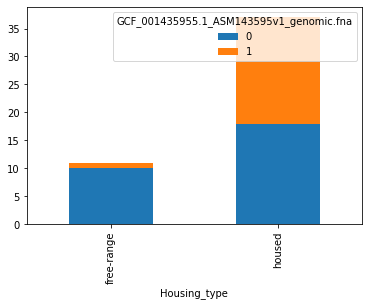

In [56]:
pd.crosstab(meta_binary_genome_info['Housing_type'],meta_binary_genome_info['GCF_001435955.1_ASM143595v1_genomic.fna']).plot.bar(stacked=True)


Only with two genomes where there statisicly significant difference between free-range and housed - in both cases was the lactobacillus found more in the housed chickens. - after adding adjusted p values no species were significant

#### Difference in pooled vs individual replica 

In [57]:
meta_binary_genome_info['Sample,replicate'].unique()

array(['pooled digesta from five chickens',
       'digesta from one chicken (biological replicate 3)',
       'digesta from one chicken (biological replicate 2)',
       'digesta from one chicken (biological replicate 1)',
       'digesta from one chicken', 'pooled digesta from 25 chickens'],
      dtype=object)

In [58]:
def condition_on_replicate(s):
#     'cage', 'free-range', ' conventional_broiler_house'):
    if 'pooled' in s['Sample,replicate']:
        return 'pooled'
    else:
        return 'single_replicate'

In [59]:
meta_binary_genome_info['replicate_type'] = meta_binary_genome_info.apply(condition_on_replicate, axis=1)

In [60]:
significant_diff_replicate_type = stat_diff(meta_binary_genome_info, 'replicate_type', 'pooled', 'single_replicate')

In [61]:
significant_diff_replicate_type

{'GCF_001435955.1_ASM143595v1_genomic.fna': [RanksumsResult(statistic=3.4996520862250624, pvalue=0.0004658657645859117),
  0.02655434858139697]}

results before adjusting for p values

{'GCF_000159355.1_ASM15935v1_genomic.fna': RanksumsResult(statistic=2.5825745817022296, pvalue=0.009806616350195418),
 'GCF_000159435.1_ASM15943v1_genomic.fna': RanksumsResult(statistic=2.1609297520365596, pvalue=0.030700766246158417),
 'GCF_001435955.1_ASM143595v1_genomic.fna': RanksumsResult(statistic=3.4996520862250624, pvalue=0.0004658657645859117),
 'GCF_005405465.1_ASM540546v1_genomic.fna': RanksumsResult(statistic=2.2030942350031264, pvalue=0.027588107445987248),
 'S28C2674.fna': RanksumsResult(statistic=-2.139847510553276, pvalue=0.03236709220632542),
 'S2C205.fna': RanksumsResult(statistic=2.0449774238785, pvalue=0.040857083895312285),
 'S2C3320.fna': RanksumsResult(statistic=2.066059665361784, pvalue=0.038822846144609124),
 'S5C1113.fna': RanksumsResult(statistic=2.487704495027454, pvalue=0.01285705135032739)}

In 8 cases there were statistical evidence for significant difference in the distribution of a genome based on replicate type - 8 genomes were statistically found more in pooled than single replicates.  only one after adjusted p values 

<AxesSubplot:xlabel='replicate_type'>

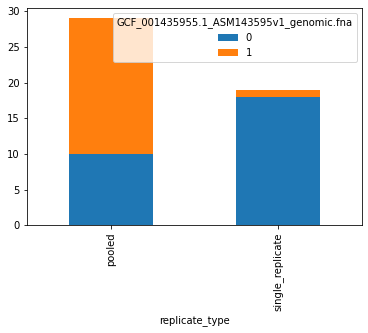

In [62]:
pd.crosstab(meta_binary_genome_info['replicate_type'],meta_binary_genome_info['GCF_001435955.1_ASM143595v1_genomic.fna']).plot.bar(stacked=True)


Most of the pooled data was from europe - so checking to see how many of the significant genomes were also significantly from europe. 

In [63]:
pooled_set = set(list(significant_diff_replicate_type.keys()))
europe_set = set((list(mostly_present_europe.keys())))

pooled_set - europe_set

set()

Out of 8 genomes that were more present in pooled samples 6 of them are more present in europe. 

To look pooled vs single replicate without region factoring we look at only farm china2, china6, china1, and china3 which is 9 pooled and 5 individual replicates from Hunan and Beijing in China

In [64]:
replicate_type_china = meta_binary_genome_info[meta_binary_genome_info['farm_ID'].isin(['china2', 'china1', 'china3', 'china6'])]

In [65]:
significant_diff_replicate_type_china = stat_diff(replicate_type_china, 'replicate_type', 'pooled', 'single_replicate')

In [66]:
significant_diff_replicate_type_china

{}

Out of 14 genomes 2 were significantly different, but barely ( close to 0.05) - zero after adjusted p-value

#### Difference in broiler vs layer

In [67]:
meta_binary_genome_info['type'].unique()

array(['broiler', 'layer'], dtype=object)

In [68]:
significant_diff_type = stat_diff(meta_binary_genome_info, 'type', 'broiler', 'layer')

In [69]:
significant_diff_type

{}

<AxesSubplot:xlabel='type'>

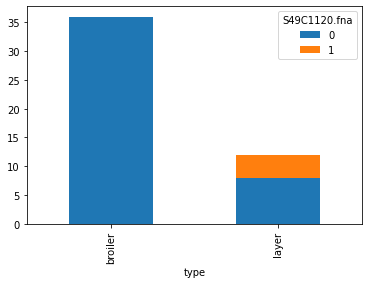

In [70]:
pd.crosstab(meta_binary_genome_info['type'],meta_binary_genome_info['S49C1120.fna']).plot.bar(stacked=True)


only two genomes have a significant difference between layers and broilers, with layers having the genome present in the most samples.  - zero after p value adjustment



In [74]:
meta_binary_genome_info.to_csv('data56_related_files/metadata_out.tsv', index=False)

In [84]:
meta_binary_genome_info

,Dataset,ID,Country,gender,"age,days,",Breed,"isolation,location",type,Feed,Temperature,...,S42C891.fna,S49C1120.fna,S4C569.fna,S52C595.fna,S5C1113.fna,S8C2455.fna,S9C3913.fna,region,Housing_type,replicate_type
0,Huang,SRR6323252,China,male,42,Arbor Acres broiler,duodenum,broiler,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,1,0,0,0,0,0,0,china,housed,pooled
1,Huang,SRR6323384,China,male,42,Arbor Acres broiler,ileum,broiler,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,1,0,0,0,0,0,0,china,housed,pooled
2,Huang,SRR6323414,China,male,42,Arbor Acres broiler,jejunum,broiler,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,1,0,0,0,1,0,0,china,housed,pooled
3,Huang,SRR6323550,China,male,42,Arbor Acres broiler,colorectum,broiler,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,0,0,0,0,0,0,0,china,housed,pooled
4,Huang,SRR6323556,China,female,42,Local yellow-feather chickens,cecum,layer,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,0,0,0,0,0,0,0,china,housed,pooled
5,Huang,SRR6323530,China,female,42,Local yellow-feather chickens,ileum,layer,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,1,1,0,0,1,0,0,china,housed,pooled
6,Huang,SRR6323503,China,female,42,Local yellow-feather chickens,colorectum,layer,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,0,1,0,0,0,0,0,china,housed,pooled
7,Huang,SRR6323350,China,female,42,Local yellow-feather chickens,jejunum,layer,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,1,1,0,0,0,0,0,china,housed,pooled
8,Huang,SRR6323197,China,female,42,Local yellow-feather chickens,duodenum,layer,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,1,1,0,0,1,0,0,china,housed,pooled
9,Huang,SRR6323247,China,male,42,Arbor Acres broiler,cecum,broiler,None,reduced from 35 °C on day 1 to 24 °C on day 21...,...,0,0,0,0,0,0,0,china,housed,single_replicate


### Confidence intervals 

calculating the confidence intervals for each of the statisitcally significant p-values stating a strain be more present in one region than another given a confidence level of 95%. what is the difference in proportions in present and absence in the two populations. Using the formular below where 
* p^ is the proportion of successes 
* q^ is the proportion of failures
* Z is the Z score which can be looked up in at table or calculatied using scipy.stats.zscore() giving alpha/2
* alpha is 1 - Confidence level. 
* n is the number of samples 


( https://www.statisticshowto.com/probability-and-statistics/confidence-interval/ ) 
(https://stackoverflow.com/questions/20864847/probability-to-z-score-and-vice-versa)

NB. using the z-score it assumes normallity.

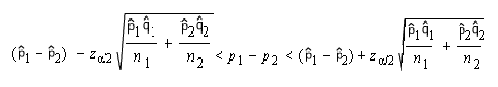

In [83]:
Image(filename = "CI_with_2_populations.png", width=500, height=300)

In [195]:
def CI_calculations( n1, n2, success1, success2, CL = 0.95):
    
    p_hat1 = success1/n1
    q_hat1 = (n1-success1)/n1
    
    p_hat2 = success2/n2
    q_hat2 = (n2-success2)/n2

    alpha = 1 - CL
    
    if p_hat1 - p_hat2 < 0: # otherwise we get the negative equviallent 
        temp1 = p_hat1
        p_hat1 = p_hat2
        p_hat2 = temp1
        
        temp2 = q_hat1
        q_hat1 = q_hat2
        q_hat2 = temp2

        temp3 = n1
        n1 = n2
        n2 = temp3
    
    under_the_sqrt = np.sqrt((p_hat1*q_hat1)/n1 + (p_hat2*q_hat2)/n2)
    Z = norm.ppf(1-(alpha/2))
    leftside = Z * under_the_sqrt
    
    lower = (p_hat1 - p_hat2) - leftside
    higher = (p_hat1 - p_hat2) + leftside
  
    return (lower, higher)

In [196]:
def CI_multiple_gneomes(df, genome_list):
    
    n1 = 25 #europe
    n2 = 23 #china 
    grouped_region_df =df.groupby('region').sum()
    
    CI_interval_dict = {}
    
    for genome in genome_list:
        success1 = grouped_region_df[genome][1]
        success2 = grouped_region_df[genome][0]
        
        CI_interval_dict[genome] = CI_calculations(n1=n1, n2=n2, success1=success1, success2=success2, CL=0.95) 

    return CI_interval_dict

In [197]:
CI_multiple_gneomes(df=meta_binary_genome_info, genome_list=statistical_region_genomes_ranksum.keys())

{'GCF_000159355.1_ASM15935v1_genomic.fna': (0.6842971311710713,
  0.9887463470897984),
 'GCF_000159435.1_ASM15943v1_genomic.fna': (0.4525217178505854,
  0.8587826299755015),
 'GCF_000614735.1_ASM61473v1_genomic.fna': (0.6719449705009479,
  0.9871854642816607),
 'GCF_001435955.1_ASM143595v1_genomic.fna': (0.5295102614999047,
  0.903533216760965),
 'GCF_001436315.1_ASM143631v1_genomic.fna': (0.4817820843606695,
  0.8712613939002001),
 'GCF_002088015.1_ASM208801v1_genomic.fna': (0.3549617759186814,
  0.7824295284291447),
 'GCF_005405465.1_ASM540546v1_genomic.fna': (0.24541989275169648,
  0.6345801072483035),
 'GCF_013694365.1_ASM1369436v1_genomic.fna': (0.460929175601701,
  0.8782012591809077),
 'S16C442.fna': (0.613182979437845, 0.9589909336056331),
 'S18C2441.fna': (0.557362985930269, 0.9278544053740788),
 'S24C362.fna': (0.6719449705009479, 0.9871854642816607),
 'S2C3320.fna': (0.5032980160840445, 0.9019193752203035),
 'S4C569.fna': (0.6719449705009479, 0.9871854642816607)}

In [248]:
# looking at confidence intervals from all genomes. 
CI_multiple_gneomes(df=meta_binary_genome_info, genome_list=statistical_region_genomes.keys())

{'GCA_900557215.1_UMGS2022_genomic.fna': (0.13714470864828204,
  0.5028552913517179),
 'GCF_000016825.1_ASM1682v1_genomic.fna': (-0.026344979985533423,
  0.18634497998553343),
 'GCF_000159355.1_ASM15935v1_genomic.fna': (0.6842971311710713,
  0.9887463470897984),
 'GCF_000159435.1_ASM15943v1_genomic.fna': (0.4525217178505854,
  0.8587826299755015),
 'GCF_000160575.1_ASM16057v1_genomic.fna': (-0.007201191908109805,
  0.2680707571255011),
 'GCF_000193635.1_ASM19363v1_genomic.fna': (0.08141420999491758,
  0.44032492043986504),
 'GCF_000423265.1_ASM42326v1_genomic.fna': (0.009510261499904638,
  0.3835332167609649),
 'GCF_000614735.1_ASM61473v1_genomic.fna': (0.6719449705009479,
  0.9871854642816607),
 'GCF_000615285.1_ASM61528v1_genomic.fna': (-0.08149674762898568,
  0.30758370415072483),
 'GCF_001433855.1_ASM143385v1_genomic.fna': (-0.036814586821684946,
  0.11681458682168494),
 'GCF_001434785.1_ASM143478v1_genomic.fna': (-0.036814586821684946,
  0.11681458682168494),
 'GCF_001435345.1_ASM

In [84]:
meta_binary_genome_info[meta_binary_genome_info['ID'] == 'SRR9113737']['farm_ID']

27    UK
Name: farm_ID, dtype: object